# CS182 Project: Introduction to EfficientNet


### Part1: introduction
EfficientNet is a family of convolutional neural networks that were designed to provide state-of-the-art accuracy on image classification tasks while maintaining a high level of efficiency. Developed by a team of researchers at Google, EfficientNet models use a novel compound scaling method to balance the number of parameters in the network with its depth and width, resulting in a highly optimized architecture that achieves superior performance with fewer computational resources. EfficientNet models have achieved top scores in various computer vision benchmarks, including the ImageNet dataset, and have been widely adopted for a range of applications, including object detection, segmentation, and transfer learning.

In this HW, we're going to implement EfficientNet from scratch, and understand how EfficientNets are "efficient" in the sense of cost of compuation and number of parameters

Imports and preparations:

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
DRIVE_PATH = '/content/gdrive/My\ Drive/cs182project_eq_efficientnet'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs182project_eq_efficientnet'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

# Torch stuff
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision

import os, random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#training part
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm
import logging
import argparse
import random
import copy

import json

In [4]:
! git clone https://github.com/ethanqiu04/tinyimagenet
#Originally Taken from Stanford CS231n, Li Fei Fei et al. will cite later
#Basically miniimagenet, but smaller, you might even call it, tinyimagenet
#I did some preprocessing to remove some painpoints via the data_dealing jupyternotebook in the github
! ls 'tinyimagenet/'

fatal: destination path 'tinyimagenet' already exists and is not an empty directory.
data_dealing.ipynb  organized_val  README.md  test  train  wnids.txt  words.txt


In [5]:
TRAIN_PATH = 'tinyimagenet/train'
VAL_PATH = 'tinyimagenet/organized_val'
TEST_PATH = 'tinyimagenet/test'

About the data we're using: Tiny-ImageNet is a dataset for computer vision tasks that was created by Stanford University as a smaller version of the popular ImageNet dataset. It contains 200 object classes, each with 500 training images, 50 validation images, and 50 test images, making a total of 100,000 images in the dataset. The images in Tiny-ImageNet are resized to 64x64 pixels and are similar to the ones in the original ImageNet dataset, but with a much smaller size, making it an ideal dataset for testing and evaluating computer vision models on limited computational resources.

In this part we're going to implement a dataloader. The purpose of this is to build a convenient way to feed data from a dataset to a model during training or inference. With the DataLoader, users can easily handle large datasets and apply different data augmentation techniques to the input data. The PyTorch DataLoader is a flexible and efficient tool that has become a standard part of many deep learning workflows.

In [6]:
def produce_dataloader_dataset(data_path, label, transform):
    dataset = datasets.ImageFolder(data_path, transform=transform)
    if label == "train":
      dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
    else:
      dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
    return dataloader, dataset

In [7]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        
    ]
)

validation_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


test_transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


Question 1a): setup train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset in the following block. You can use the code in the previous block as a reference.
Hint: check out function: produce_dataloader_dataset

In [8]:
#######################
# TODO: your code here#
#######################
train_loader, train_dataset = produce_dataloader_dataset(TRAIN_PATH, "train", train_transform)
val_loader, val_dataset = produce_dataloader_dataset(VAL_PATH, "val", validation_transform)
test_loader, test_dataset = produce_dataloader_dataset(TEST_PATH, "test", test_transform)
#######################
#END OF YOUR CODE    #
#######################

In [29]:
#helper functions for displaying images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    

def dump_batch(dataloader):
    data_iterator = iter(dataloader)
    images, labels = next(data_iterator)
    imshow(torchvision.utils.make_grid(images[:5])) 
    print('   '.join(f'{id_to_label_dict[labels[j].tolist()]:5s}' for j in range(5)))

def imgclass_to_labels(path):
    class_label_dict = {}
    with open(path + "/words.txt", 'r') as words_file:
        for line in words_file:
            split_line = line.split()
            split_line = [i.replace(",", "") for i in split_line]
            img_class = split_line[0]
            class_label = '_'.join(split_line[1:])
            if class_label in class_label_dict:
                print('something went wrong')
            class_label_dict[img_class] = class_label
    return class_label_dict

def labeling_helper(dataset, class_label_dict):
    dataset_dict = dataset.class_to_idx
    torch_id_to_class_label = {}
    for img_class, torch_id in dataset_dict.items():
        torch_id_to_class_label[torch_id] = class_label_dict[img_class]
    return torch_id_to_class_label

In [30]:
class_label_dict = imgclass_to_labels('tinyimagenet/')
list(class_label_dict.items())[:10]

[('n00001740', 'entity'),
 ('n00001930', 'physical_entity'),
 ('n00002137', 'abstraction_abstract_entity'),
 ('n00002452', 'thing'),
 ('n00002684', 'object_physical_object'),
 ('n00003553', 'whole_unit'),
 ('n00003993', 'congener'),
 ('n00004258', 'living_thing_animate_thing'),
 ('n00004475', 'organism_being'),
 ('n00005787', 'benthos')]

In [31]:
id_to_label_dict = labeling_helper(train_dataset, class_label_dict)

list(id_to_label_dict.items())[:5]

[(0, 'goldfish_Carassius_auratus'),
 (1, 'European_fire_salamander_Salamandra_salamandra'),
 (2, 'bullfrog_Rana_catesbeiana'),
 (3, 'tailed_frog_bell_toad_ribbed_toad_tailed_toad_Ascaphus_trui'),
 (4, 'American_alligator_Alligator_mississipiensis')]

sock    desk    scoreboard   pay-phone_pay-station   golden_retriever


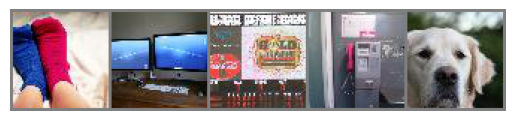

In [35]:
dump_batch(train_loader)

Question: What's the shape of data in train_loader for a sigle batch? (in terms of [N, C, H, W])

Answer: 256, 3, 64, 64

### Part 2: Building the model


The "highlight" of EfficientNet is its use of compound scaling methods. Compound scaling in essence is to use a coefficient to uniformaly scale the 3 Dimensions (depth, width and resolution) of the model. The coefficient is denoted as $\phi$ in the paper. The scaling method is as follows:

$$
 depth: d = \alpha^\phi \\
 width: w = \beta^\phi \\
 resolution: r = \gamma^\phi \\
 \alpha \cdot \beta^2 \cdot \gamma ^2 \approx 2\\
\alpha \geq 1, \beta \geq 1, \gamma \geq 1

$$ 

The author created a family of EfficientNet models with different $\phi$ values, and the best model is EfficientNet-B7 with $\phi = 2.0$. In this HW, we're going to implement EfficientNet-B0 with $\phi = 1.0$, which is the smallest model in the family.

Firstly we'going to implement some tricks the author used that makes EfficientNet efficient. The first technique is called Squeeze and Excitation (SE). SE is very similiar to the attention mechanism. It is used to help the model to focus on the most important features. The SE module is implemented as follows: 

![image](./imgs/SE.jpeg)

In [13]:
# Implement the Squueze and Excitation block down below
# Note that though the image above shows we're using ReLu as the activation function, we're actually using SiLU (swish)
# as the author mentioned in the paper that it performed better than ReLU. We also replace the avgpool with adaptiveavgpool
# for the same reason.
# Hint: use nn.AdaptiveAvgPool2d(1) to replace nn.AvgPool2d(1) and nn.SiLU() to replace nn.ReLU()
class SqueezeExcitation(nn.Module):
    def __init__(self, n_in, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        #######################
        # TODO: your code here#
        #######################
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_in, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, n_in, kernel_size=1),
            nn.Sigmoid()
        )
        #######################
        # End of your code    #
        #######################
    
    def forward(self, x):
        #######################
        # TODO: your code here#
        #######################
        y = self.se(x)
        #######################
        # End of your code    #
        #######################
        # Hint: consider why what the picture means by scaling and why we're multiplying here
        return x * y

Next we're going to implement the trick: Stochastic Depth, which makes the entire training process much faster. The gist of it is to randomly drop a subset of layers and bypass them with the identity function during training. And a full network is used during testing/inference. The image below shows the implementation of Stochastic Depth:

![image](./imgs/SD.jpeg)

In [14]:
# Implement the Stochastic Depth block down below
# Hint: use torch.rand() to generate a random number

class StochasticDepth(nn.Module):
    
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        
        self.p =  survival_prob
        
    def forward(self, x):
        #######################
        # TODO: your code here#
        #######################
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        return torch.div(x, self.p) * binary_tensor
        #######################
        # End of your code    #
        #######################

In [15]:
# Here we provide you with the simple Conv-BatchNorm-Activation block for you
# Note that we're using SiLU (swish) as the activation function instead of ReLU as the author mentioned in the paper 
# that it performed better than ReLU

class ConvBnAct(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, stride = 1, 
                 padding = 0, groups = 1, bn = True, act = True,
                 bias = False
                ):
        
        super(ConvBnAct, self).__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = kernel_size,
                              stride = stride, padding = padding,
                              groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x

Finally here come the finally implementation of EfficientNet. Some additional tricks the author used here include Depthwise Separable Convolution, which is a combination of depthwise convolution and pointwise convolution. The depthwise convolution is used to extract features from each channel, and the pointwise convolution is used to combine the features from different channels.

The image below shows the implementation of Depthwise Separable Convolution:

![image](./imgs/DSC.jpeg)

In [16]:
# We start by implementing Residual Bottleneck Block with Expansion Factor = N as defined in Mobilenet-V2 paper
# with Squeeze and Excitation Block and Stochastic Depth. 
# The process of implementation: residual -> exapnd -> depthwise conv 
# -> squeeze and excitation -> pointwise conv -> skip connection

class MBConvN(nn.Module):
    def __init__(self, n_in, n_out, kernel_size = 3, 
                 stride = 1, expansion_factor = 6,
                 reduction = 4, # Squeeze and Excitation Block
                 survival_prob = 0.8 # Stochastic Depth
                ):
        
        super(MBConvN, self).__init__()
        #######################
        # TODO: your code here#
        #######################
        self.skip_connection = (stride == 1 and n_in == n_out) 
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1)//2
        reduced_dim = int(n_in//reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, intermediate_channels, kernel_size = 1)
        self.depthwise_conv = ConvBnAct(intermediate_channels, intermediate_channels,
                                        kernel_size = kernel_size, stride = stride, 
                                        padding = padding, groups = intermediate_channels
                                       )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim = reduced_dim)
        self.pointwise_conv = ConvBnAct(intermediate_channels, n_out, 
                                        kernel_size = 1, act = False
                                       )
        self.drop_layers = StochasticDepth(survival_prob = survival_prob)
        #######################
        # End of your code    #
        #######################
        
    def forward(self, x):
        residual = x
        #######################
        # TODO: your code here#
        #######################
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        #######################
        # End of your code    #
        #######################
        return x


In [17]:
# Here comes the acutal implmentation of EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, width_mult = 1, depth_mult = 1, 
                dropout_rate = 0.2, num_classes = 1000):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(1280 * width_mult)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
    def _feature_extractor(self, width_mult, depth_mult, last_channel):
        
        channels = 4*ceil(int(32*width_mult) / 4)
        layers = [ConvBnAct(3, channels, kernel_size = 3, stride = 2, padding = 1)]
        in_channels = channels
        
        # These are from the paper
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        # Scale channels and num_layers according to width and depth multipliers.
        scaled_num_channels = [4*ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        #######################
        # TODO: your code here#
        #######################
        for i in range(len(scaled_num_channels)):
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                            scaled_num_channels[i],
                            kernel_size = kernels[i],
                            stride = strides[i] if repeat==0 else 1, 
                            expansion_factor = expansions[i]
                            )
                    for repeat in range(scaled_num_layers[i])
                    ]
            in_channels = scaled_num_channels[i]
        #######################
        # End of your code    #
        #######################
        
        layers.append(ConvBnAct(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0))
    
        return nn.Sequential(*layers)

In [18]:
# Compound scaling factors for efficient-net family.
efficient_net_config = {
    # tuple of width multiplier, depth multiplier, resolution, and Survival Prob
    # from the paper
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}

Finally we're going to train our implemented model. Follow the code instruction below to train the model. We recommend to use GPU to train the model. 

In [19]:
def calculate_loss_and_accuracy(model, dataloader, size_of_dataset, criterion):
    
    # Now set model to validation mode.
    running_loss = 0
    running_accuracy = 0
    
    # Processing the Test Loader
    for (inputs, labels) in dataloader:
        
        # Load data to device.
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Loss and Backpropagation.
        loss = criterion(outputs, labels)
        
        # Statistics
        running_loss += loss.item()*inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss/size_of_dataset
    epoch_accuracy = running_accuracy/size_of_dataset
    
    return epoch_loss, epoch_accuracy

def train(model, criterion, optimizer, scheduler, num_of_epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    track_training_loss = []
    track_val_loss = []

    for epoch in range(num_of_epochs):

        print(f'\nEpoch {epoch + 1}/{num_of_epochs}')
        print('-'*30)

        model.train() # Setting model to train.
        running_loss = 0
        running_accuracy = 0

        # Processing the Train Loader
        for (inputs, labels) in train_loader:

            # Load data to device.
            #######################
            # TODO: your code here#
            #######################
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # zero the parameter gradients
            #######################
            # End of your code    #
            #######################

            # Outputs
            outputs = model(inputs)
            _ , preds = torch.max(outputs, 1)

            # Loss and Backpropagation.
            #######################
            # TODO: your code here#
            #######################
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #######################
            # End of your code    #
            #######################
            # Statistics
            running_loss += loss.item()*inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)
        
        scheduler.step()
        epoch_loss = running_loss/len(train_dataset)
        epoch_accuracy = running_accuracy/len(train_dataset)
        track_training_loss.append(epoch_loss) # Loss Tracking

        print(f'Training Loss: {epoch_loss:.4f} Training Acc.: {epoch_accuracy:.4f}')

        # Now set model to validation mode.
        model.eval()

        val_loss, val_accuracy = calculate_loss_and_accuracy(model, val_loader, len(val_dataset), criterion)
        track_val_loss.append(val_loss) 
        if val_accuracy > best_acc:
            print("Found better model...")
            print('Updating the model weights....\n')
            print(f'Val Loss: {val_loss:.4f} Val Acc.: {val_accuracy:.4f}\n')

            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
     
    model.load_state_dict(best_model_wts) # update model
    
    return  model

In [28]:
BATCH_SIZE = 256
NUM_OF_CLASSES = 200
NUM_OF_EPOCHS = 10
device = torch.device('cpu')

# Initialize Efficientnet model
version = 'b0'
width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = NUM_OF_CLASSES)
model = model.to(device) # Load model to device.

# Criterion.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



# Training
best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_OF_EPOCHS
                  )


Epoch 1/10
------------------------------


KeyboardInterrupt: ignored

Question: What is the best accuracy you can get? What is the best accuracy you can get with the same number of parameters as the EfficientNet-B0 model? Try to use different models and find the one with the best validation accuracy.

## References

[1] Mingxing Tan, Quoc V. Le. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. https://arxiv.org/abs/1905.11946